In [ ]:
!pip install duckdb
import pandas as pd 
import requests 
from io import StringIO
import os
import duckdb

def load_data(endpoint_url_ext):
    
    file_path = f"datasets/{endpoint_url_ext.split('/')[-1]}"
    if os.path.exists(file_path):
        print(f'File {file_path} already loaded.') 
        return file_path
        
    resp = requests.get(f'https://www.fema.gov/api/open/{endpoint_url_ext}')
    
    assert resp.status_code == 200
    
    content = resp.content
    with open(file_path, 'wb') as file:
        file.write(content)
    print('Success')
    return file_path
    
claims_endpoint = 'v2/FimaNfipClaims.csv'
policies_endpoint = 'v2/FimaNfipPolicies.csv'

claims_data_path = load_data(claims_endpoint)
load_data(policies_endpoint)


claims_data_path

File datasets/FimaNfipClaims.csv already loaded.


In [4]:
duckdb.read_csv(claims_data_path,)
sample = duckdb.sql(f"""select * from '{claims_data_path}' limit 10""").df()
sample 

,agricultureStructureIndicator,asOfDate,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,...,rentalPropertyIndicator,state,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,0,2020-11-13 14:50:38.288,2,1,<NA>,2020-09-16,0,None,6.0,10.0,...,0,AL,Currently Unavailable,36542,01003,01003011407,010030114073,30.3,-87.7,c6299aa9-9834-4f5d-b02c-87971bad6b55
1,0,2020-12-11 16:25:40.587,0,1,<NA>,2020-09-16,1,None,4.0,10.0,...,0,AL,Currently Unavailable,36542,01003,01003011407,010030114072,30.3,-87.7,0c269e85-3096-43e3-8f8e-a4560cdd03c0
2,0,2020-03-27 12:15:45.887,0,1,<NA>,2016-08-02,0,2,NaN,NaN,...,0,AZ,Currently Unavailable,85015,04013,04013108902,040131089022,33.5,-112.1,5352a57e-fefd-4f17-9dab-83c95f21dee6
3,0,2020-03-27 12:15:45.887,0,1,<NA>,2014-09-08,0,2,NaN,NaN,...,0,AZ,Currently Unavailable,85015,04013,04013108902,040131089022,33.5,-112.1,c1dd55c6-1ac2-48ba-aaaf-77e1a808c4df
4,0,2020-03-26 12:56:27.476,0,1,<NA>,2018-01-09,1,None,NaN,NaN,...,0,CA,Currently Unavailable,93108,06083,06083001402,060830014022,34.4,-119.6,8477a378-3885-4edb-9d3e-df9fca498327
5,0,2020-02-28 12:34:10.953,0,1,<NA>,2012-10-29,0,None,NaN,NaN,...,0,CT,Currently Unavailable,06880,09001,09001050400,090010504002,41.1,-73.4,6017143a-3c74-4f89-bf58-4c4faaeeddb6
6,0,2022-07-28 11:35:36.727,0,1,<NA>,2005-07-09,0,None,0.0,1.0,...,0,FL,Currently Unavailable,32566,12113,12113010817,121130108173,30.4,-86.9,4747d777-b457-4614-a35a-28ee49222aeb
7,0,2020-01-22 16:55:53.194,0,1,<NA>,2017-09-10,1,2,NaN,NaN,...,0,FL,Currently Unavailable,34145,12021,12021010903,120210109031,25.9,-81.7,84c2944e-9b47-4df4-a3f4-4958d7075c57
8,0,2022-07-28 11:35:36.727,0,1,<NA>,2004-09-16,0,None,0.0,1.0,...,0,FL,Currently Unavailable,32566,12113,12113010817,121130108173,30.4,-86.9,7a6fafd2-8e1b-4c30-9da0-927a130e93bd
9,0,2023-03-31 20:23:46.063,0,1,<NA>,2005-08-26,0,None,2.0,9.0,...,0,FL,Currently Unavailable,33187,12086,12086010300,120860103007,25.6,-80.5,04034cb0-a726-4e14-861d-302a09eb2681


In [7]:
sample.columns

Index(['agricultureStructureIndicator', 'asOfDate',
       'basementEnclosureCrawlspaceType', 'policyCount',
       'crsClassificationCode', 'dateOfLoss', 'elevatedBuildingIndicator',
       'elevationCertificateIndicator', 'elevationDifference',
       'baseFloodElevation', 'ratedFloodZone', 'houseWorship',
       'locationOfContents', 'lowestAdjacentGrade', 'lowestFloorElevation',
       'numberOfFloorsInTheInsuredBuilding', 'nonProfitIndicator',
       'obstructionType', 'occupancyType', 'originalConstructionDate',
       'originalNBDate', 'amountPaidOnBuildingClaim',
       'amountPaidOnContentsClaim',
       'amountPaidOnIncreasedCostOfComplianceClaim',
       'postFIRMConstructionIndicator', 'rateMethod',
       'smallBusinessIndicatorBuilding', 'totalBuildingInsuranceCoverage',
       'totalContentsInsuranceCoverage', 'yearOfLoss',
       'primaryResidenceIndicator', 'buildingDamageAmount',
       'buildingDeductibleCode', 'netBuildingPaymentAmount',
       'buildingPropertyValu

In [20]:
con = duckdb.connect()
con.sql(
    f"""
    create table nfip_claims as 
    select * from read_csv('{claims_data_path}', strict_mode=False)
    """, 
)

In [22]:
sample = \
con.sql(
'''
drop table if exists nfip_claims_truncated
;

create table nfip_claims_truncated as 
select 
    id,
    asOfDate, 
    dateOfLoss,
    policyCount as insuredUnits, 
    baseFloodElevation, 
    ratedFloodZone, 
    occupancyType, 
    originalConstructionDate, 
    originalNBDate, 
    coalesce(amountPaidOnBuildingClaim,0) +                  
    coalesce(amountPaidOnContentsClaim,0) +                  
    coalesce(amountPaidOnIncreasedCostOfComplianceClaim,0) as totalClaim, 
    coalesce(totalBuildingInsuranceCoverage,0) + 
    coalesce(totalContentsInsuranceCoverage,0) as totalCovered, 
    coalesce(buildingDamageAmount,0) + coalesce(contentsDamageAmount,0) as totalDamageLoss, 
    buildingDeductibleCode, 
    contentsDeductibleCode,
    causeOfDamage, 
    buildingPropertyValue, 
    floodproofedIndicator, 
    floodEvent, 
    state, 
    reportedZipCode, 
    censusTract, 
    latitude, 
    longitude
from nfip_claims
;

select * from nfip_claims_truncated limit 10
;
'''
)

sample.df()

,id,asOfDate,dateOfLoss,insuredUnits,baseFloodElevation,ratedFloodZone,occupancyType,originalConstructionDate,originalNBDate,totalClaim,...,contentsDeductibleCode,causeOfDamage,buildingPropertyValue,floodproofedIndicator,floodEvent,state,reportedZipCode,censusTract,latitude,longitude
0,c6299aa9-9834-4f5d-b02c-87971bad6b55,2020-11-13 14:50:38.288,2020-09-16,1,10.0,AE,2,1975-01-01,2008-10-20,2695.44,...,None,1,167531,0,Hurricane Sally,AL,36542,01003011407,30.3,-87.7
1,0c269e85-3096-43e3-8f8e-a4560cdd03c0,2020-12-11 16:25:40.587,2020-09-16,1,10.0,AE,1,1991-09-17,2017-10-05,2871.18,...,F,1,278027,0,Hurricane Sally,AL,36542,01003011407,30.3,-87.7
2,5352a57e-fefd-4f17-9dab-83c95f21dee6,2020-03-27 12:15:45.887,2016-08-02,1,NaN,AH,1,1949-01-01,2014-09-02,0.00,...,5,4,140422,0,None,AZ,85015,04013108902,33.5,-112.1
3,c1dd55c6-1ac2-48ba-aaaf-77e1a808c4df,2020-03-27 12:15:45.887,2014-09-08,1,NaN,AH,1,1949-01-01,2014-09-02,25156.27,...,5,4,140919,0,None,AZ,85015,04013108902,33.5,-112.1
4,8477a378-3885-4edb-9d3e-df9fca498327,2020-03-26 12:56:27.476,2018-01-09,1,NaN,AE,1,1960-01-01,2001-08-05,0.00,...,0,4,<NA>,0,Mid-Winter California Flooding,CA,93108,06083001402,34.4,-119.6
5,6017143a-3c74-4f89-bf58-4c4faaeeddb6,2020-02-28 12:34:10.953,2012-10-29,1,NaN,AE,1,1950-02-02,2003-04-01,18240.94,...,None,1,201932,0,Hurricane Sandy,CT,06880,09001050400,41.1,-73.4
6,4747d777-b457-4614-a35a-28ee49222aeb,2022-07-28 11:35:36.727,2005-07-09,1,1.0,AOB,1,1982-07-01,1995-02-24,26122.96,...,0,1,51304,0,None,FL,32566,12113010817,30.4,-86.9
7,84c2944e-9b47-4df4-a3f4-4958d7075c57,2020-01-22 16:55:53.194,2017-09-10,1,NaN,VE,1,1979-01-01,2017-02-02,0.00,...,A,2,408928,0,Hurricane Irma,FL,34145,12021010903,25.9,-81.7
8,7a6fafd2-8e1b-4c30-9da0-927a130e93bd,2022-07-28 11:35:36.727,2004-09-16,1,1.0,AOB,1,1982-07-01,1995-02-24,38506.45,...,0,1,66338,0,Hurricane Ivan,FL,32566,12113010817,30.4,-86.9
9,04034cb0-a726-4e14-861d-302a09eb2681,2023-03-31 20:23:46.063,2005-08-26,1,9.0,AHB,1,1993-01-01,2001-06-25,8212.62,...,0,4,49019,0,Hurricane Katrina,FL,33187,12086010300,25.6,-80.5


In [24]:
con.sql(
'''
select 
    column_name, 
    null_percentage
from (summarize from nfip_claims_truncated)
order by 2 desc
;
'''    
)

┌──────────────────────────┬─────────────────┐
│       column_name        │ null_percentage │
│         varchar          │  decimal(9,2)   │
├──────────────────────────┼─────────────────┤
│ baseFloodElevation       │           75.66 │
│ floodEvent               │           28.19 │
│ buildingPropertyValue    │           23.16 │
│ contentsDeductibleCode   │           20.70 │
│ buildingDeductibleCode   │           11.65 │
│ ratedFloodZone           │            5.14 │
│ censusTract              │            5.11 │
│ reportedZipCode          │            2.06 │
│ latitude                 │            1.52 │
│ longitude                │            1.52 │
│ causeOfDamage            │            1.41 │
│ originalConstructionDate │            0.06 │
│ occupancyType            │            0.02 │
│ totalDamageLoss          │            0.00 │
│ dateOfLoss               │            0.00 │
│ totalCovered             │            0.00 │
│ totalClaim               │            0.00 │
│ state      

In [26]:
con.sql('''
select column_name, min, max 
from (summarize from nfip_claims_truncated)
where column_type == 'TIMESTAMP'
;
'''
)

┌──────────────────────────┬─────────────────────────┬─────────────────────────┐
│       column_name        │           min           │           max           │
│         varchar          │         varchar         │         varchar         │
├──────────────────────────┼─────────────────────────┼─────────────────────────┤
│ asOfDate                 │ 2019-09-19 06:12:43.388 │ 2025-01-03 02:20:08.421 │
│ dateOfLoss               │ 1978-01-01 00:00:00     │ 2025-01-02 00:00:00     │
│ originalConstructionDate │ 1201-01-01 00:00:00     │ 2024-11-14 00:00:00     │
│ originalNBDate           │ 0998-09-21 00:00:00     │ 2025-01-10 00:00:00     │
└──────────────────────────┴─────────────────────────┴─────────────────────────┘

In [28]:
#filter analysis by type of disaster?
claims_zip = '''
select 
    reportedZipCode, 
    state,
    count(id) as claimCounts,
    sum(insuredUnits) as policyCounts, 
    sum(totalClaim) as totalClaimZip, 
    sum(totalDamageLoss) as totalLossesZip
from nfip_claims_truncated
where dateOfLoss >= '2000-01-01'
group by 1,2
having count(id) > 10
order by 5 desc
;
'''

claim_summary_zip = con.sql(claims_zip).df()

claim_summary_zip['normalizedClaimZip'] = claim_summary_zip['totalClaimZip']/claim_summary_zip['claimCounts']
claim_summary_zip['normalizedLossZip'] = claim_summary_zip['totalLossesZip']/claim_summary_zip['claimCounts'] 

claim_summary_zip.head(10)

,reportedZipCode,state,claimCounts,policyCounts,totalClaimZip,totalLossesZip,normalizedClaimZip,normalizedLossZip
0,70124,LA,8964,9605.0,1.311962e+09,1.564395e+09,146359.007936,174519.721107
1,70043,LA,9158,9158.0,1.147166e+09,1.514149e+09,125263.852152,165336.228216
2,70122,LA,10978,11056.0,1.039922e+09,1.317953e+09,94727.794602,120053.983786
3,70126,LA,9575,9575.0,8.914090e+08,1.211701e+09,93097.549521,126548.376292
4,33908,FL,8274,14321.0,8.495124e+08,8.780766e+08,102672.512536,106124.802272
5,70458,LA,11024,11621.0,8.134363e+08,9.202128e+08,73787.758531,83473.584906
6,70128,LA,6317,6317.0,7.091043e+08,9.369830e+08,112253.331038,148327.213234
7,77096,TX,5326,6174.0,6.672587e+08,7.017863e+08,125283.278671,131766.108900
8,70127,LA,6411,6453.0,6.558297e+08,8.725647e+08,102297.560538,136104.303541
9,33957,FL,6764,13552.0,6.319699e+08,6.467247e+08,93431.386923,95612.756062


In [30]:
claim_summary_zip.sort_values(by=['totalLossesZip'], ascending=False)

,reportedZipCode,state,claimCounts,policyCounts,totalClaimZip,totalLossesZip,normalizedClaimZip,normalizedLossZip
0,70124,LA,8964,9605.0,1.311962e+09,1.564395e+09,146359.007936,174519.721107
1,70043,LA,9158,9158.0,1.147166e+09,1.514149e+09,125263.852152,165336.228216
2,70122,LA,10978,11056.0,1.039922e+09,1.317953e+09,94727.794602,120053.983786
3,70126,LA,9575,9575.0,8.914090e+08,1.211701e+09,93097.549521,126548.376292
6,70128,LA,6317,6317.0,7.091043e+08,9.369830e+08,112253.331038,148327.213234
...,...,...,...,...,...,...,...,...
8951,93203,CA,12,12.0,1.049421e+04,6.081000e+03,874.517500,506.750000
8960,21108,MD,12,12.0,1.240080e+03,5.581000e+03,103.340000,465.083333
8961,32835,FL,12,12.0,0.000000e+00,6.840000e+02,0.000000,57.000000
8962,93241,CA,11,11.0,0.000000e+00,0.000000e+00,0.000000,0.000000


In [32]:
by_state = claim_summary_zip.groupby(['state'])[['claimCounts','totalClaimZip','totalLossesZip']].sum()
by_state['normalizedClaimZip'] = by_state['totalClaimZip']/by_state['claimCounts']
by_state['normalizedLossZip'] = by_state['totalLossesZip']/by_state['claimCounts']

by_state.sort_values(by=['normalizedLossZip'],ascending=False).head(10)

,claimCounts,totalClaimZip,totalLossesZip,normalizedClaimZip,normalizedLossZip
state,,,,,
MS,36854,2.884185e+09,3.598015e+09,78259.762824,97628.891247
LA,328395,1.946950e+10,2.301520e+10,59286.835194,70083.903430
TX,268102,1.579858e+10,1.672838e+10,58927.485540,62395.585106
NY,108683,5.327278e+09,5.606677e+09,49016.663994,51587.437180
VT,2400,9.757368e+07,1.136085e+08,40655.698513,47336.871667
IA,8049,2.848500e+08,3.709801e+08,35389.492072,46090.209964
NJ,134567,5.886679e+09,6.074625e+09,43745.341126,45142.010612
VI,1045,4.199988e+07,4.653364e+07,40191.271435,44529.795215
FL,312056,1.350085e+10,1.383715e+10,43264.194027,44341.886017


### Exploratory Data Analysis 

Analyze the total flood-induced losses (property + contents) across different US States according to the NFIP claims dataset. Build zipcode-level geo-plots measuring both total losses and normalized losses (per claim). 

**** Processed zip geo-template for GA ****
**** Processed zip geo-template for FL ****
**** Processed zip geo-template for AL ****
**** Processed zip geo-template for MS ****
**** Processed zip geo-template for LA ****
**** Processed zip geo-template for SC ****


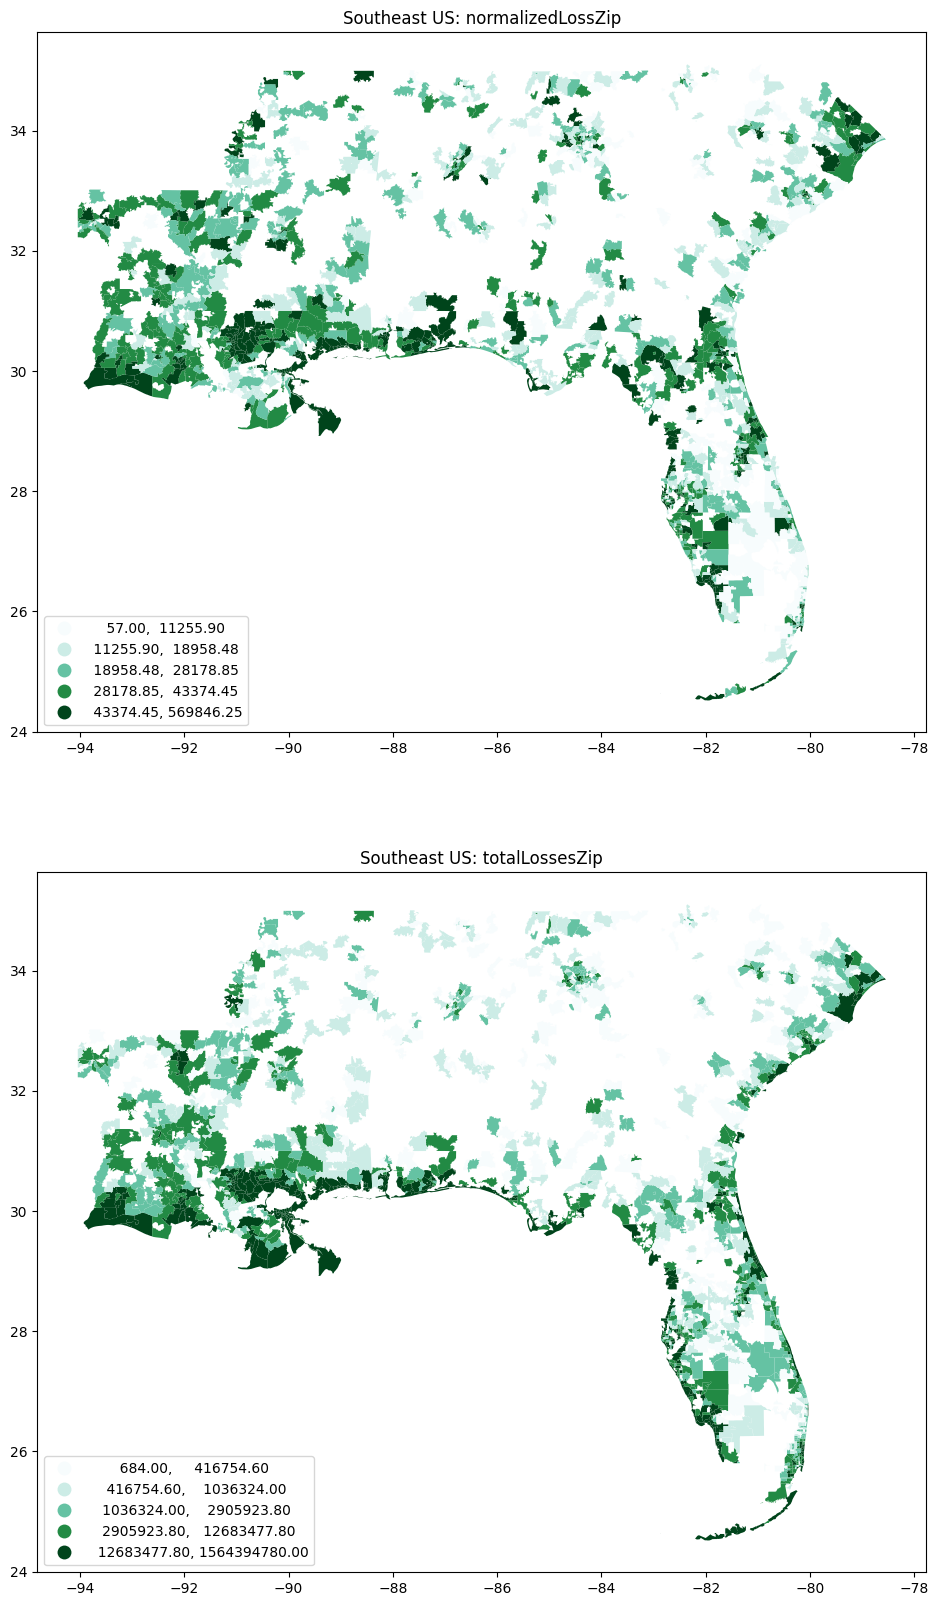

**** Processed zip geo-template for NY ****
**** Processed zip geo-template for NJ ****
**** Processed zip geo-template for CT ****


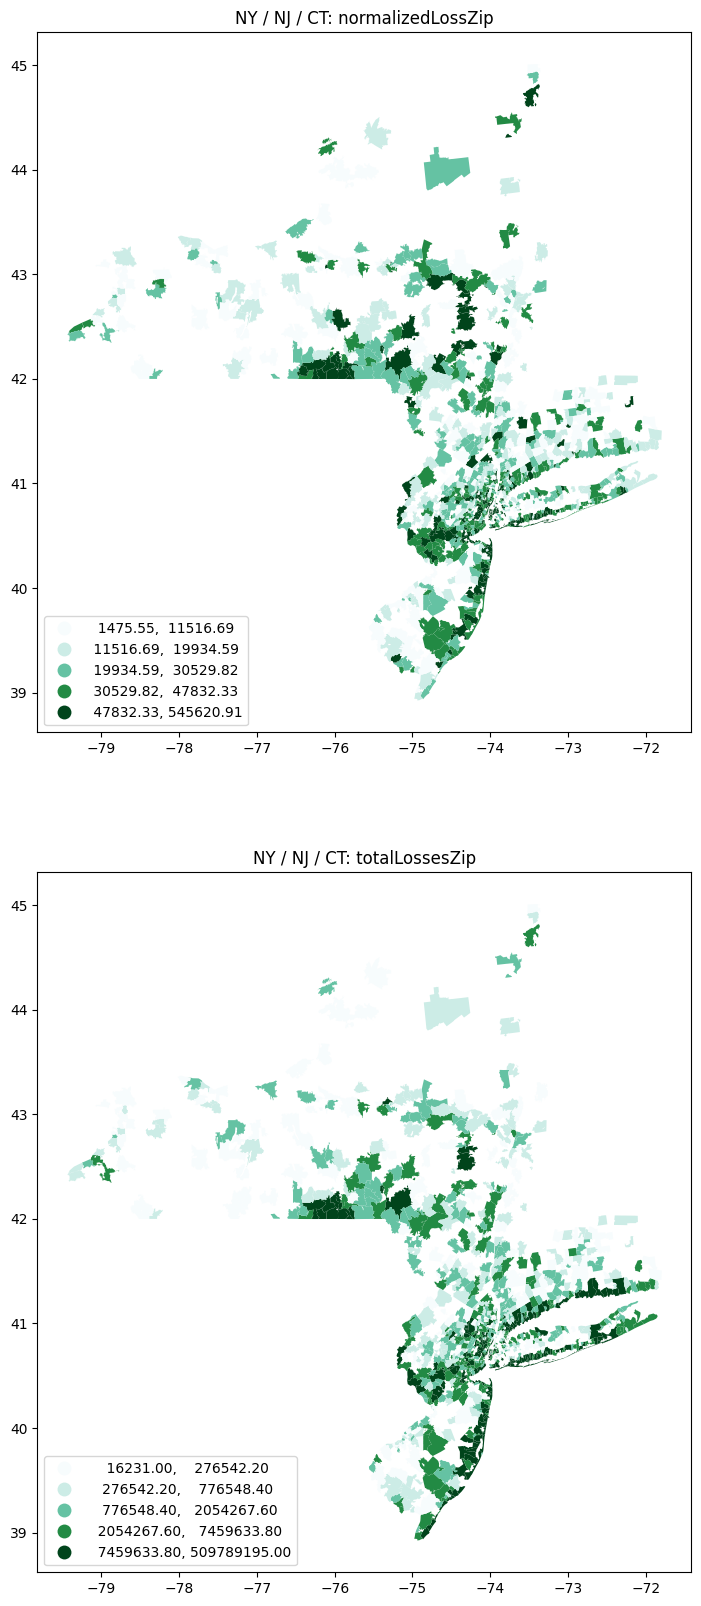

In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt 

def create_geo_df_zips(geo_jsons, parent_df=claim_summary_zip):

    path = 'datasets/State-zip-code-GeoJSON/'
    states, geo_dfs = [], []
    for json in geo_jsons: 
      
        read_file = gpd.read_file(path+json)[['ZCTA5CE10','geometry']]
        template_file = read_file.rename(columns={'ZCTA5CE10':'reportedZipCode'})
        geo_dfs.append(template_file)

        state = json[:2].upper() 
        print(f'**** Processed zip geo-template for {state} ****')
        states.append(state) 

    template_total = pd.concat(geo_dfs)
    flood_insurance_claims = parent_df.loc[parent_df['state'].isin(states)]
    flood_insurance_claims_w_zip_geo = flood_insurance_claims.merge(
        template_total, 
        how='inner', 
        on='reportedZipCode'
    )
    
    flood_insurance_claims_w_zip_geo = gpd.GeoDataFrame(flood_insurance_claims_w_zip_geo)

    return flood_insurance_claims_w_zip_geo

def geo_plot_flood_losses(geo_jsons, features, prefix): 

    data = create_geo_df_zips(geo_jsons) 

    fig, ax = plt.subplots(2,1,figsize=(15,20),constrained_layout=False)
    for f, _ax in list(zip(features, ax)): 
        data.plot(
            column=f, 
            legend=True, 
            markersize=0.01,
            figsize=(10,10),
            scheme='Quantiles', 
            legend_kwds={'loc': 'lower left'},
            cmap='BuGn',
            ax=_ax
        ) 
        _ax.set_title(f'{prefix}: {f}') 
    plt.show()

############# generate plots ##############

features = [
    'normalizedLossZip',
    'totalLossesZip'
]

southeast_us_zips = [
    'ga_georgia_zip_codes_geo.min.json',
    'fl_florida_zip_codes_geo.min.json', 
    'al_alabama_zip_codes_geo.min.json', 
    'ms_mississippi_zip_codes_geo.min.json',
    'la_louisiana_zip_codes_geo.min.json', 
    'sc_south_carolina_zip_codes_geo.min.json'
]

geo_plot_flood_losses(
    southeast_us_zips, 
    features, 
    'Southeast US'
)

tristate_zips = [
    'ny_new_york_zip_codes_geo.min.json', 
    'nj_new_jersey_zip_codes_geo.min.json', 
    'ct_connecticut_zip_codes_geo.min.json'
]

geo_plot_flood_losses(
    tristate_zips, 
    features, 
    'NY / NJ / CT'
)


#### Time Series analysis

Have the number of claims/losses grown over time over certain regions? 

Sidenotes: 

* Losses per HH seem to slightly increase over time on a log-scale (though this needs to be verified). Is this attributable to market inflation over time (of contents, property values), or the severity of climate-induced storms?
* Are the magnitudes of each claim "spike" proportional to population growth around more vulnerable areas? What's the true disaster "effect" that can be captured from those spikes?


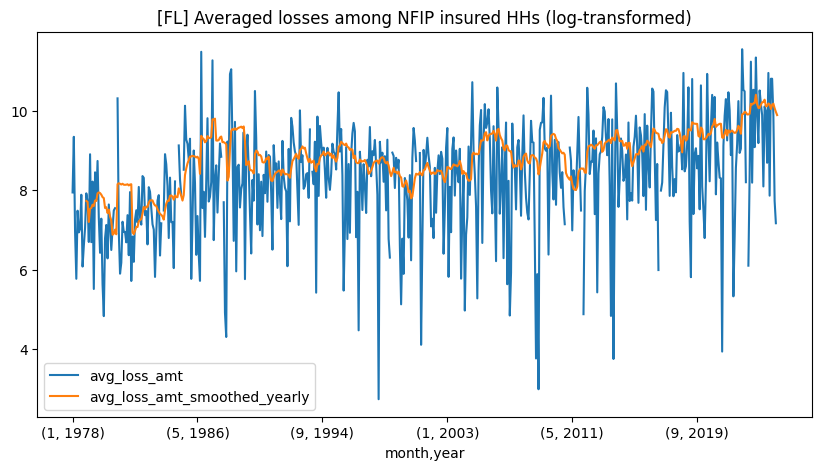

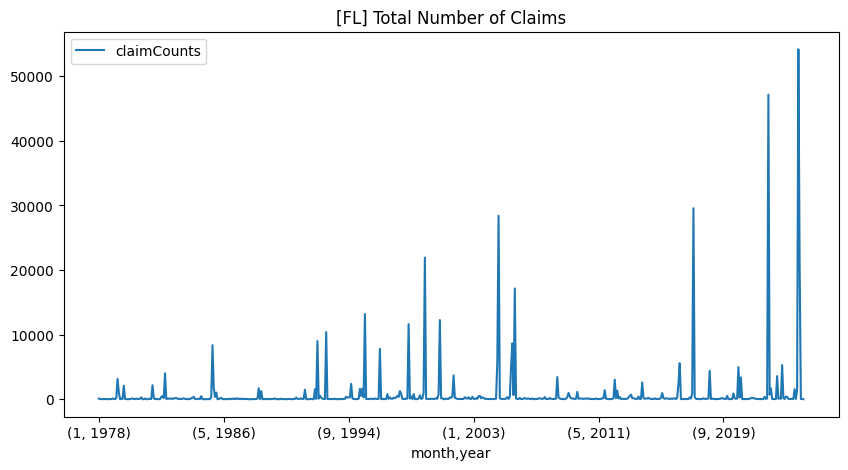

In [38]:
import numpy as np
ts = '''
drop table if exists nfip_ts_view
;

create table nfip_ts_view as
select 
    extract(month from dateOfLoss::date) as month,
    extract(year from dateOfLoss::date) as year,    
    reportedZipCode, 
    state,
    count(id) as claimCounts,
    sum(insuredUnits) as policyCounts, 
    sum(totalClaim) as totalClaimZip, 
    sum(totalDamageLoss) as totalLossesZip
from nfip_claims_truncated
group by 1,2,3,4
order by 2,1 
;
'''


con.sql(ts) 

ts_by_state = '''
select 
    *, 
    totalClaims / claimCounts as avg_claim_amt, 
    totalLosses / claimCounts as avg_loss_amt
from (
select 
    month,
    year, 
    sum(claimCounts) as claimCounts, 
    sum(policyCounts) as policyCounts, 
    sum(totalClaimZip) as totalClaims, 
    sum(totalLossesZip) as totalLosses
from nfip_ts_view 
where state = '{state}'
group by 1,2
order by 2,1
)
;

'''

####### analyze for a single state, say FL
fl_claims_over_time = con.sql(
    ts_by_state.format(
        state = 'FL'
    )
).df()

fl_claims_over_time.head(10)
fl_claims_over_time['avg_claim_amt_smoothed_yearly'] = fl_claims_over_time['avg_claim_amt'].rolling(12).mean()
fl_claims_over_time['avg_loss_amt_smoothed_yearly'] = fl_claims_over_time['avg_loss_amt'].rolling(12).mean()
fl_claims_over_time['claim_count_smoothed_yearly'] = fl_claims_over_time['claimCounts'].rolling(12).mean()
fl_claims_over_time['total_losses_smoothed_yearly'] = fl_claims_over_time['avg_loss_amt'].rolling(12).mean()

fl_claims_over_time\
    .set_index(['month','year'])[['avg_loss_amt','avg_loss_amt_smoothed_yearly']]\
    .apply(np.log)\
    .plot(
        figsize=(10,5), 
        title='[FL] Averaged losses among NFIP insured HHs (log-transformed)'
    )
plt.show()

fl_claims_over_time\
    .set_index(['month','year'])[['claimCounts']]\
    .plot(
        figsize=(10,5), 
        title='[FL] Total Number of Claims'
    )
plt.show()
